In [17]:
# Download a part of ImageNet
!git clone https://github.com/skaldek/ImageNet-Datasets-Downloader DOWNLOADER

!mkdir DATA
!mkdir DATA_FINAL
!mkdir PRECALCULATED
!mkdir CHECKPOINTS
!mkdir GRAPHS

# Smaller dataset used for testing different configurations
# ImageNet classes used: vehicle, armored car, fishing boat, airplane, bumper car
!python DOWNLOADER/downloader.py \
    -data_root DATA \
    -use_class_list True \
    -class_list n06255081 n02739889 n03351262 n02691156 n02918964 \
    -images_per_class 10000

# Bigger dataset used for the final model
# ImageNet classes used: vehicle, armored car, fishing boat, airplane, bumper car, boat racing, auto racing, racing, motorcycling, bicycling
!python DOWNLOADER/downloader.py \
    -data_root DATA_FINAL \
    -use_class_list True \
    -class_list n06255081 n02739889 n03351262 n02691156 n02918964 n00449695 n00449517 n00449295 n00451635 n00451563 \
    -images_per_class 10000

fatal: destination path 'DOWNLOADER' already exists and is not an empty directory.
A subdirectory or file DATA already exists.
A subdirectory or file PRECALCULATED already exists.
A subdirectory or file CHECKPOINTS already exists.


Picked the following clases: 
Count: 10
['vehicle', 'armored car', 'fishing boat', 'airplane', 'bumper car', 'boat racing', 'auto racing', 'racing', 'motorcycling', 'bicycling']
Multiprocessing workers: 8

Scraping stats:
STATS For class is_flickr:
 tried 242.0 urls with 124.0 successes
51.239669421487605% success rate for is_flickr urls 
0.07032237706645843 seconds spent per is_flickr successful image download
STATS For class not_flickr:
 tried 0.0 urls with 0.0 successes
STATS For class all:
 tried 242.0 urls with 124.0 successes
51.239669421487605% success rate for all urls 
0.07032237706645843 seconds spent per all successful image download

Scraping stats:
STATS For class is_flickr:
 tried 492.0 urls with 279.0 successes
56.707317073170735% success rate for is_flickr urls 
0.05669823598690785 seconds spent per is_flickr successful image download
STATS For class not_flickr:
 tried 0.0 urls with 0.0 successes
STATS For class all:
 tried 492.0 urls with 279.0 successes
56.70731707317


100%|##########| 10/10 [03:50<00:00, 23.00s/it]


In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import rc
from scipy.ndimage import gaussian_filter
from skimage import io, color
from torch.utils.data import DataLoader
from torchvision import transforms

import dataset
from euclidean_model import EuclideanModel
from model import Model
from simplified_model import SimplifiedModel

In [2]:
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NVIDIA GeForce GTX 1060 6GB


In [3]:
def show(images: torch.Tensor, size: int =2, grayscale: bool =False):
    """
    Show a list of images in a (N/6)x6 grid
    :param images: list of images in LAB
    :param size: plot size
    :param grayscale: true if grayscale
    :return: None
    """
    rows = np.ceil(len(images) / 6.0)

    plt.figure(figsize=(int(size * 6), int( size * rows)))
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

    if grayscale:
        m = images
    else:
        m = Model.lab_to_rgb(images)

    for i, image in enumerate(m):
        plt.subplot(int(rows), 6, i + 1)

        if grayscale:
            image = image[0, :, :]
            plt.imshow(image, cmap="gray")
        else:
            plt.imshow(image)
        plt.axis("off")
    plt.show()

In [ ]:
# As mentioned in the report, we implemented a different approach for computing the mapping function between t: (a, b) --> Q as well.

# shows how we originally made use of our own mask file to compute distributions
# must_compute_p = True
# if must_compute_p:
#   # mask = torch.load('mask.pt')
#   # p = torch.load('p.pt')
#   # q_length = p[mask].size(dim=0)
#   # q_length = len(mask)
# else:
#   q_length = 26**2



# def from_q_to_smallq(original_Q_distribution, mask):
#   return original_Q_distribution[:, mask]

# def from_smallq_to_q(small_q_distribution, mask):
#   original_q_distribution = torch.zeros(len(mask))

#   idx = 0
#   for idx_originalq, value in enumerate(mask):
#     if value.item() == True:
#       original_q_distribution[idx_originalq] = small_q_distribution[idx]
#       idx +=1

#   return original_q_distribution


# def from_q_to_smallq(original_Q_distribution, mask):
#   return original_Q_distribution[mask]

# def H_inv(ass,bs, mask):
#   H,W = ass.shape ; bin_count = 26 ; Q = bin_count**2 # 676

#   small_Q = mask.count_nonzero()

#   Z = np.zeros((H,W,small_Q)) # Is a Z with newQ dimension

#   for h_iter,row in enumerate(ass):
#     for w_iter,a in enumerate(row):
#       aidx= a//10   # //floor

#       b = bs[h_iter][w_iter] #pixel          range: 0-255
#       bidx= b//10  # //floor
#       distribution = np.zeros((bin_count,bin_count))
#       distribution[aidx,bidx] = 1

#       distribution = distribution.flatten()

#       Z[h_iter][w_iter] = from_q_to_smallq(distribution, mask) #todo
#   return Z


# from matplotlib.patches import BoxStyle
# # H^−1
# def from_q_to_smallq(original_Q_distribution, mask):
#   return original_Q_distribution[:, :, mask]

# def H_inv(a_batch, b_batch, mask):
#     b, H, W = a_batch.shape
#     bin_count = 26
#     Q = bin_count ** 2

#     a_batch = np.reshape(a_batch, (b, H*W))
#     b_batch = np.reshape(b_batch, (b, H*W))
#     small_Q = mask.count_nonzero()

#     aidxs = a_batch // 10
#     bidxs = b_batch // 10

#     distribution = np.zeros((b, H*W, Q))

#     for batch_idx in range(b):
#       distribution[batch_idx, np.arange(H*W), np.dot(aidxs[batch_idx], bin_count) + bidxs[batch_idx]] = 1

#     Z = from_q_to_smallq(distribution, mask)
#     Z = np.reshape(Z, (b, H, W, small_Q))
#     return Z



# def image_from_Z_and_L(Z, L, Q=222):
#   height, width = L.shape
#   lab_image = np.zeros((height,width,3) , dtype=np.uint8)
#   xs = torch.arange(start=0, end=Q, step=1)
#   for h_idx, row in enumerate(Z):
#     print(width, h_idx)

#     for w_idx, Z_hw in enumerate(row):

#       l = L[h_idx, w_idx]

#       Z_hw_orig_distr = from_smallq_to_q(Z_hw, mask) # Z_hw is 222 -> we go to 676 again

#       a, b = H(Z_hw_orig_distr, Q)

#       lab_image[h_idx][w_idx][0] = l
#       lab_image[h_idx][w_idx][1] = a
#       lab_image[h_idx][w_idx][2] = b

#   return lab_image

# gray = train_features[0] # (l)
# im1 = train_labels[0] # Z: (a, b)
# im = image_from_Z_and_L(im1, gray, 26*26)
# show([im])

In [1]:
def H(Z_batch, T, q_to_ab):
    """
    H function maps the predicted Z batch to the corresponding a, b values
    :param Z_batch: predicted batch of Z values
    :param T: temperature variable, controls the strength of peaks in the distribution
    :param q_to_ab: (Q, 2) Tensor, maps each Q value to its corresponding (a, b) pair
    :return: ab: batch of predicted (a, b) values
    """
    (b, Q, h, w) = Z_batch.shape
    # Y_batch shape:((b, 2, h, w))
    Z_batch = torch.permute(Z_batch, (1, 0, 2, 3))  # (Q, b, h, w)
    Z_batch = Z_batch.reshape((Q, b*h*w))  # (Q, b*h*w)

    if T == 0:
        # if T == 0 -> compute mode
        Qs = torch.argmax(Z_batch, axis=0)  # (shape: b*h*w)

        ab_pairs = q_to_ab[Qs]  # shape: (b*h*w, 2)

        # y_batch: (b, 2, h, w)
        Y_batch = ab_pairs

    else:
        # https://github.com/Time0o/colorful-colorization
        distributions_rescaled = torch.exp(Z_batch / T,)
        distributions_rescaled /= distributions_rescaled.sum(dim=0, keepdim=True)

        expected_as = torch.sum(distributions_rescaled * q_to_ab[:, 0].unsqueeze(-1), dim=0)
        expected_bs = torch.sum(distributions_rescaled * q_to_ab[:, 1].unsqueeze(-1), dim=0)

        Y_batch = torch.stack((expected_as, expected_bs), dim=0) # shape: (2, b*h*w)
        Y_batch = Y_batch.permute(1, 0)

    Y_batch = Y_batch.reshape((b, h, w, 2)).permute(0, 3, 1, 2)
    return Y_batch

# The code below is based from original writers. https://github.com/Time0o/colorful-colorization
# The authors did not explicitly mention how their Q bins were derived.
# We originally wrote our own H-inv, H functions which were based on our own mask (See comments above).
# The mask we computed ourselves based on the dataset.
# This technique, however, caused issues when going from continuous colour space to a discrete colour space.
# eg if a pixel (a, b) = (74, 44) would get discretised to similar colours (70, 40),
# it could be that this (a, b) colour is invisible, and hence get removed by the mask,
# resulting in an empty pixel distribution, although the original pixel was clearly
# visible.
def H_inv(y_batch, q_to_ab, neighbours):
    """
    Maps the (a, b) values back to a discretized representation.
    :param y_batch: (batch, c, h, w) Tensor, where c=2 and contains the (a,b) values for each pixel
    :param q_to_a_b: (Q, 2) Tensor, maps each Q value to a corresponding (a, b) pair
    :param neighbours: int, number of nearest neighbours to consider for each (a, b) value
    :return: (batch, Q, h, w) Tensor, representing the discretized version of the (a, b) values
    """
    # values between 0 and 100 and -110 to +110
    b, c, h, w = y_batch.shape
    y_batch_permuted = y_batch.permute(1, 0, 2, 3).reshape(2, -1)
    cdist = torch.cdist(q_to_ab, y_batch_permuted.t())
    nns = (cdist.sort(dim=0)[1])[:neighbours, :]  # 5, 64*64*8
    nn_gauss = y_batch_permuted.new_zeros(neighbours, b * h * w)

    sigma = 5
    norm = 1 / (2 * np.pi * sigma)
    for i in range(neighbours):
         # Compute the gaussian probability density for each neighbour
        nn_gauss[i, :] = norm * torch.exp(
            -torch.sum((q_to_ab[nns[i, :], :].t() - y_batch_permuted) ** 2, dim=0) / (2 * sigma ** 2))

    # normalize
    nn_gauss /= nn_gauss.sum(dim=0, keepdim=True)
    bins = 313
    q = y_batch.new_zeros(bins, b * h * w)
    q[nns, torch.arange(b * h * w).repeat(neighbours, 1)] = nn_gauss
    Z = q.reshape(bins, b, h, w).permute(1, 0, 2, 3)
    return Z

In [5]:
def compute_p(dataloader, Q_shape, q_to_ab):
    """
    Compute the distribution of (ab)-values based on the given data loader and the shape of the q-values.
    :param dataloader: dataloader containing the data
    :param Q_shape: shape of the q-values
    :param q_to_ab: mapping from q-values to (ab)-values
    :return: distribution of (ab)-values
    """
    p = torch.zeros(Q_shape)
    for idx, batch in enumerate(dataloader):
        print("idx: ", idx)

        # (batch, c, h, w)
        ab = batch[:, 1:, :, :]
        Z_batch = H_inv(ab, q_to_ab, 1)

        # Z_batch: (8, 313, 64, 64)
        b, Q, H, W, = Z_batch.shape
        Z_batch = torch.permute(Z_batch, (0, 2, 3, 1))  # b, H, W, Q,

        # (b*H*W, Q)
        Z_batch_flat = Z_batch.reshape((b * H * W, Q_shape))
        p_batch = torch.sum(Z_batch_flat, dim=0)
        p += p_batch
        p /= p.sum()
    return p

def smooth(p):
    """
    Applies a gaussian filter to the distribution with a sigma of 5, and then normalizes the result.
    :param p: distribution of the (a,b) values a torch array
    :return: smoothen distribution, a torch array with the same shape as the input p
    """
    p = gaussian_filter(p, sigma=5)
    p /= p.sum()
    return p

def compute_w(p, lamb):
    """
    Compute the weights for each (ab)-value based on the p distribution and the lambda
    :param p: distribution of the (ab)-values, a torch array
    :param lamb: lambda, a float value
    return: weights, a torch array with the same shape as the input p
    """
    Q = (p > 0).sum()
    w = 1 / (((1 - lamb) * p) + lamb / Q)
    return w / sum(p * w)

def v(Z_batch, weights_to_rebalance):
    """
    Compute the class rebalancing function v based on the ground truth distribution Z_batch and the weights for rebalancing.
    The function returns the weight that corresponds to the ground truth (a,b) value in Z_batch.

    :param Z_batch: Tensor of shape (batch size, channels, height, width) representing the ground truth distribution of (a,b) values
    :param weights_to_rebalance: Tensor containing the weights for rebalancing the loss function
    :return: Tensor of shape (batch size, 1, height, width) containing the selected weight for each ground truth (a,b) value
    """
    w = weights_to_rebalance
    b, c, H, W = Z_batch.shape
    Z_batch_flattened = torch.reshape(Z_batch, (b, c, H * W))
    batch_idxs = torch.arange(b)
    # shape: (8, 64*64)
    idxs = torch.argmax(Z_batch_flattened[batch_idxs, :, :], dim=1)
    return w[idxs].reshape(b, 1, H, W)

In [6]:
def create_data_loaders(directory: str):
    """
    Create data loaders for training, validation and testing data
    :param directory: data directory
    :return: training dataloader with transformations, training dataloader without transformations, validation dataloader, test dataloader
    """

    # Split the dataset into train, validation and test sets
    split = lambda d: torch.utils.data.random_split(d, [0.8, 0.1, 0.1], torch.Generator().manual_seed(0))

    batch_size = 32
    num_workers = 4

    # Create a dataset with transformations and without, we train on the transformed data
    transformed_data = dataset.Dataset(directory, 176, True)
    full_data = dataset.Dataset(directory, 256, False)

    # Split both datasets
    train_transformed, _, _ = split(transformed_data)
    train_full, val_full, test_full = split(full_data)

    # Create dataloaders for both datasets
    train_transformed = DataLoader(train_transformed, batch_size=batch_size, num_workers=num_workers, shuffle=True,
                       collate_fn=dataset.collate_fn)
    train_full = DataLoader(train_full, batch_size=batch_size, num_workers=num_workers,
                            collate_fn=dataset.collate_fn)
    test_full = DataLoader(test_full, batch_size=batch_size, num_workers=num_workers,
                           collate_fn=dataset.collate_fn)
    val_full = DataLoader(val_full, batch_size=batch_size, num_workers=num_workers,
                          collate_fn=dataset.collate_fn)

    print("### ", directory)
    print("Dataset size: ", len(full_data))
    print("Train size: ", len(train_full) * batch_size)
    print("Validation size: ", len(val_full) * batch_size)
    print("Test size: ", len(test_full) * batch_size)

    return train_transformed, train_full, val_full, test_full

# Create dataloaders for the experiment and for the final model
train_transformed, train_full, val_full, test_full = create_data_loaders("DATA")
train_transformed_final, train_full_final, val_full_final, test_full_final = create_data_loaders("DATA_FINAL")

###  DATA
Dataset size:  2189
Train size:  1760
Validation size:  224
Test size:  224
###  DATA_FINAL
Dataset size:  5627
Train size:  4512
Validation size:  576
Test size:  576


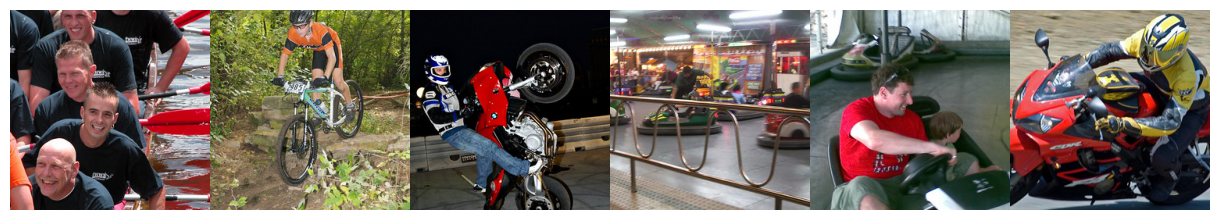

In [7]:
# Select some images for visualisations
train_images = next(iter(train_full_final))
test_images = next(iter(test_full_final))
show(train_images[:6])

In [8]:
# Load the discretised AB values
q_to_ab = torch.from_numpy(np.load("PRECALCULATED/q_to_ab.npy")).float().to(device)
q_length = q_to_ab.shape[0]

# Compute the AB distribution in the dataset if necessary
must_compute_p = False
if must_compute_p:
    new = compute_p(train_full, q_length, q_to_ab.cpu())
    torch.save(new, "PRECALCULATED/p.pt")

# Load the distribution calculated on our dataset and the one calculated on the entire ImageNet
# Also create smoothed versions
p = torch.load("PRECALCULATED/p.pt").to(device)
p_smooth = torch.tensor(smooth(p.cpu())).to(device)
p_imagenet = torch.from_numpy(np.load("PRECALCULATED/p_imagenet.npy")).to(device)
p_prior_smooth = torch.tensor(smooth(p_imagenet.cpu())).to(device)

# Use one distribution to compute the balancing weights
weights = compute_w(p, lamb=0.5)

In [10]:
# Create H and H_inv functions for encoding and decoding the AB values
h_inv = lambda ab: H_inv(ab, q_to_ab, 5)
h = lambda z: H(z, 0.38, q_to_ab)

# Initialize the cross-entropy and rebalanced cross-entropy losses
v_prepared = lambda z: v(z, weights)
cross_entropy_rebalanced = lambda y_pred, y: Model.cross_entropy_rebalanced(y_pred, y, v_prepared)
cross_entropy = Model.cross_entropy

In [11]:
# This code was modified for every model we trained, it is now configured to continue training on the final model

# Create the final model
m = SimplifiedModel(q_length, h, h_inv, cross_entropy_rebalanced).to(device)
# Load the pretrained model on the smaller dataset
m.load("simplified_final_600")

# Print the amount of parameters
print("Paremeters: ", sum(p.numel() for p in m.parameters()))

# Train the final model
m.train_model(train_transformed_final, val_full_final, 600)

# Test the final model
m.test(test_full_final)

# Visualise some predictions
show(test_images[:6])
show(m.predict(test_images[:6]))

In [11]:
####################################################################################################
# All code below was used only after the experiments were finished for creating the visualisations #
####################################################################################################

euclidean = EuclideanModel().to(device)
euclidean.load("euclidean_100")

unbalanced_onehot = Model("unbalanced_onehot", q_length, h, None, None).to(device)
unbalanced_onehot.load("unbalanced_onehot_100")

unbalanced = Model("unbalanced", q_length, h, None, None).to(device)
unbalanced.load("unbalanced_100")

rebalanced = Model("rebalanced", q_length, h, None, None).to(device)
rebalanced.load("rebalanced_100")

rebalanced_smooth = Model("rebalanced_smooth", q_length, h, None, None).to(device)
rebalanced_smooth.load("rebalanced_smooth_100")

rebalanced_ours = Model("rebalanced_ours", q_length, h, None, None).to(device)
rebalanced_ours.load("rebalanced_ours_100")

simplified = SimplifiedModel(q_length, h, None, None).to(device)
simplified.load("simplified_100")

rebalanced_ours_final = Model("rebalanced_ours_final", q_length, h, None, None).to(device)
rebalanced_ours_final.load("rebalanced_ours_final_190")

simplified_final = SimplifiedModel(q_length, h, None, None).to(device)
simplified_final.load("simplified_final_600")
simplified_final.name = "simplified_final"

models = [euclidean, unbalanced_onehot, unbalanced, rebalanced, rebalanced_smooth, rebalanced_ours, simplified, rebalanced_ours_final, simplified_final]

In [11]:
# Plot the learning curves

for m in models:
    m.plot(show=False)

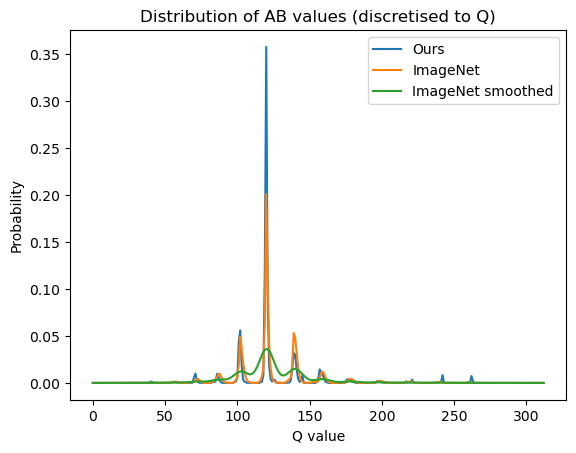

In [12]:
# Plot the distributions of AB values

plt.plot(p.cpu(), label="Ours")
plt.plot(p_imagenet.cpu(), label="ImageNet")
plt.plot(p_prior_smooth.cpu(), label="ImageNet smoothed")
plt.title("Distribution of AB values (discretised to Q)")
plt.xlabel("Q value")
plt.ylabel("Probability")
plt.legend()
plt.savefig("GRAPHS/distribution.png", bbox_inches="tight", pad_inches=0, dpi=300)

euclidean
RMSE AB: 13.572405486826954
RMSE: 0.08284471601278431
PSNR: 22.632045680273205
SSIM: 0.9236450733405439
unbalanced_onehot
RMSE AB: 13.462377272945927
RMSE: 0.08162162857795881
PSNR: 23.10040536056255
SSIM: 0.9289315901780758
unbalanced
RMSE AB: 13.248999407373276
RMSE: 0.0805520290546363
PSNR: 23.23597539678035
SSIM: 0.9296714932507344
rebalanced
RMSE AB: 18.548233090319194
RMSE: 0.10918463549693005
PSNR: 19.739948574432105
SSIM: 0.8922378030514164
rebalanced_smooth
RMSE AB: 20.831263827047426
RMSE: 0.12108516549467044
PSNR: 19.35979254527621
SSIM: 0.8683108244642604
rebalanced_ours
RMSE AB: 17.747615930464267
RMSE: 0.10546431361051449
PSNR: 20.023013773846905
SSIM: 0.896397532498116
simplified
RMSE AB: 16.146417887427326
RMSE: 0.09614172121641425
PSNR: 20.78136918888821
SSIM: 0.9069106548502963
rebalanced_ours_final
RMSE AB: 15.97549048703168
RMSE: 0.09332556066293893
PSNR: 20.934273608562805
SSIM: 0.9124165113955781
simplified_final
RMSE AB: 11.165446266735938
RMSE: 0.06487

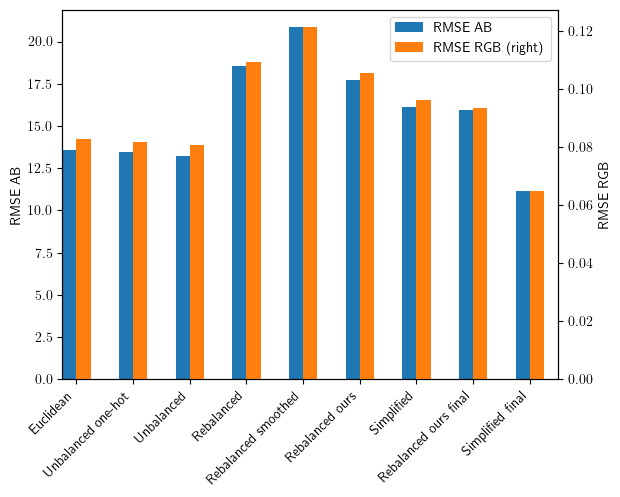

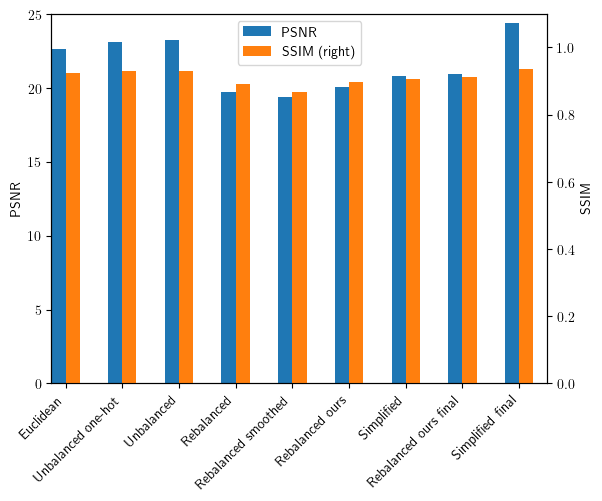

In [13]:
# Generate plots of the evaluation metrics

rc("text", usetex=True)
warnings.filterwarnings("ignore")

evals = {
    "name": [],
    "rmse_ab": [],
    "rmse": [],
    "psnr": [],
    "ssim": [],
}

for m in models:
    evals["name"].append(m.name)
    print(m.name)
    if m.name.endswith("final"):
        rmse_ab, rmse, psnr, ssim = m.test(test_full_final)
    else:
        rmse_ab, rmse, psnr, ssim = m.test(test_full)

    evals["rmse_ab"].append(rmse_ab)
    evals["rmse"].append(rmse)
    evals["psnr"].append(psnr)
    evals["ssim"].append(ssim)

df = pd.DataFrame(evals)

df.name = ["Euclidean",  "Unbalanced one-hot", "Unbalanced", "Rebalanced", "Rebalanced smoothed", "Rebalanced ours", "Simplified", "Rebalanced ours final", "Simplified final"]

ax = df.plot(x="name", y="rmse_ab", kind="bar", color="C0", width=0.25, position=1, label="RMSE AB")
df.plot(x="name", y="rmse", secondary_y=True ,kind="bar", ax=ax, color="C1", width=0.25, position=0, label="RMSE RGB")
ax.set_ylabel("RMSE AB")
ax.right_ax.set_ylabel("RMSE RGB")
ax.set_xlabel("")
plt.sca(ax)
plt.xticks(rotation=45, ha="right")
plt.savefig("GRAPHS/rmse.png", bbox_inches="tight", pad_inches=0, dpi=300)

ax = df.plot(x="name", y="psnr", kind="bar", color="C0", width=0.25, position=1, label="PSNR", ylim=(0, 25))
df.plot(x="name", y="ssim", secondary_y=True ,kind="bar", ax=ax, color="C1", width=0.25, position=0, label="SSIM", ylim=(0, 1.1))
ax.set_ylabel("PSNR")
ax.right_ax.set_ylabel("SSIM")
ax.set_xlabel("")
plt.sca(ax)
plt.xticks(rotation=45, ha="right")
plt.savefig("GRAPHS/psnr_ssim.png", bbox_inches="tight", pad_inches=0, dpi=300)

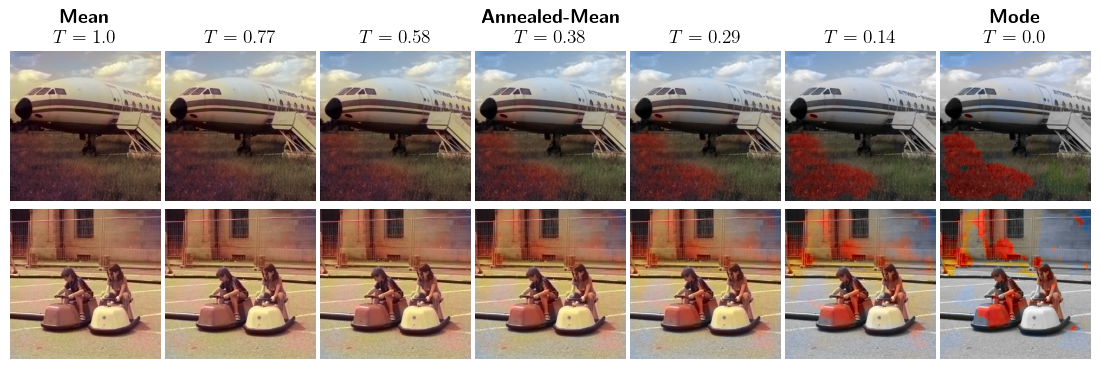

In [14]:
# Generate a figure with temperature comparisons
# We use manually cropped images to make sure interesting parts are visible

path = ["plane.jpg", "bumper_car.jpg"]
temperature_images = []

for p in path:
    img = io.imread("DATA/" + p)
    img = torch.tensor(color.rgb2lab(img).astype(np.float32)).permute(2, 0, 1)
    img.unsqueeze_(0)
    img = transforms.CenterCrop(min(img.shape[2:]))(img)
    img = transforms.Resize(256)(img)
    temperature_images.append(img)

temperature_images = torch.cat(temperature_images, dim=0).to(device)

fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(14, 4))
plt.subplots_adjust(hspace=0.05, wspace=0)

ts = [1.0, 0.77, 0.58, 0.38, 0.29, 0.14, 0.0]

for j, (row, t) in enumerate(zip(axes.T, ts)):
    h = lambda z: H(z, t, q_to_ab)
    rebalanced.h = h
    rgb = Model.lab_to_rgb(rebalanced.predict(temperature_images))
    for i, (ax, image) in enumerate(zip(row, rgb)):
        ax.imshow(image)
        ax.axis("off")
        if i == 0:
            if j == 0:
                ax.set_title(f"\\textbf{{Mean}}\n $T = {t}$", fontsize=14)
            elif j == 3:
                ax.set_title(f"\\textbf{{Annealed-Mean}}\n $T = {t}$", fontsize=14)
            elif j == 6:
                ax.set_title(f"\\textbf{{Mode}}\n $T = {t}$", fontsize=14)
            else:
                ax.set_title(f"$T = {t}$", fontsize=14)

h = lambda z: H(z, 0.38, q_to_ab)
rebalanced.h = h

fig.savefig("GRAPHS/temperature.png", bbox_inches="tight", pad_inches=0, transparent=True, dpi=300)

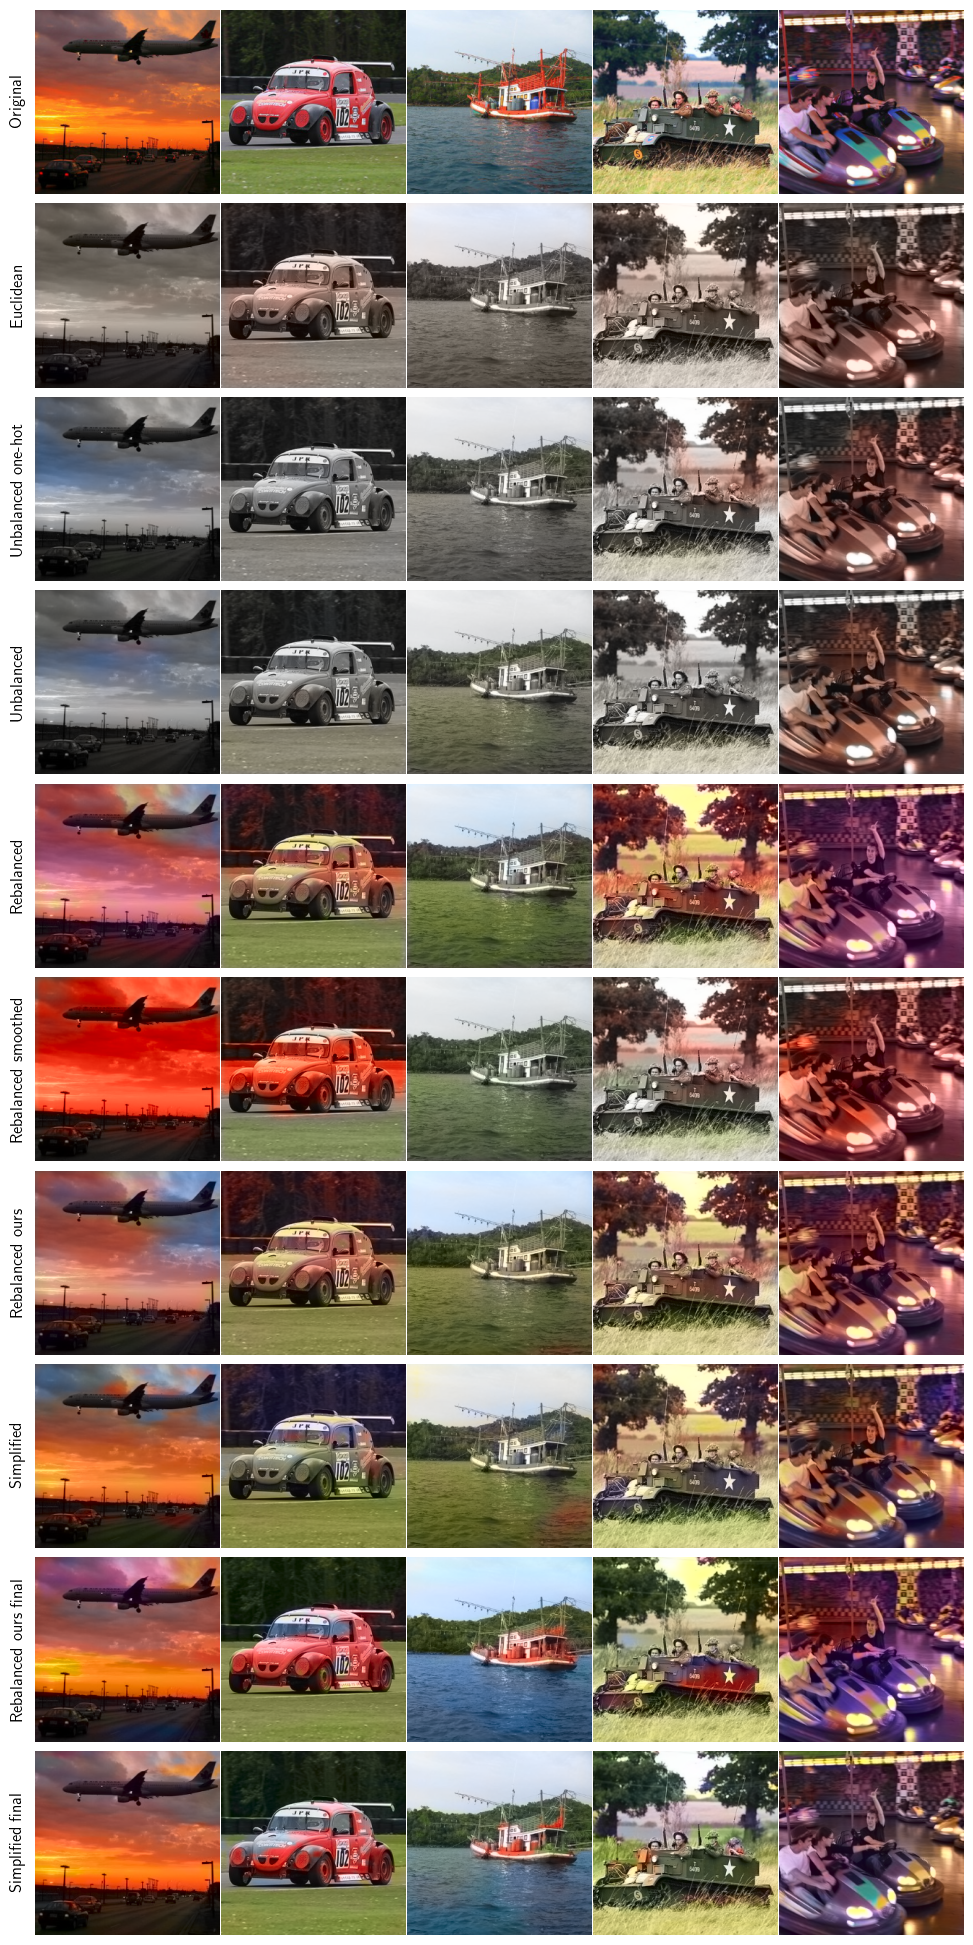

In [15]:
# Generate a figure with model comparisons
# We use manually cropped images to make sure interesting parts are visible

path = ["airplane.jpg", "vehicle.jpg", "fishing_boat.jpg", "armored_car.jpg", "bumper_car.jpg"]
comparison_images = []

for p in path:
    img = io.imread("DATA_FINAL/" + p)
    img = torch.tensor(color.rgb2lab(img).astype(np.float32)).permute(2, 0, 1)
    img.unsqueeze_(0)
    img = transforms.CenterCrop((min(img.shape[2:]), min(img.shape[2:])))(img)
    img = transforms.Resize(256)(img)
    comparison_images.append(img)

comparison_images = torch.cat(comparison_images, dim=0).to(device)

fig, axes = plt.subplots(nrows=10, ncols=comparison_images.shape[0], figsize=(int(comparison_images.shape[0] * 2.5), 25))
plt.subplots_adjust(hspace=0.05, wspace=0)

names = ["Original", "Euclidean",  "Unbalanced one-hot", "Unbalanced", "Rebalanced", "Rebalanced smoothed", "Rebalanced ours",
         "Simplified", "Rebalanced ours final", "Simplified final"]

for j, row in enumerate(axes):
    if j == 0:
        rgb = Model.lab_to_rgb(comparison_images)
    else:
        rgb = Model.lab_to_rgb(models[j - 1].predict(comparison_images))
    for i, (ax, image) in enumerate(zip(row, rgb)):
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        if i == 0:
            ax.set_ylabel(f"{names[j]}", fontsize=12)

fig.savefig("GRAPHS/comparison.png", bbox_inches="tight", pad_inches=0, transparent=True, dpi=300)